# CMPE 297 Train resNet50 on imagenet data using simCLR in tensorflow
## Team Equality - Abhishek Bais, Haley Feng, Princy Joy, Shannon Phu    
### Acknowledgements: [Towards Self-Supervised Image Understanding with SimCLR](https://github.com/sayakpaul/SimCLR-in-TensorFlow-2)

# 1.0 Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
!nvidia-smi

Sun Nov  7 17:58:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2.0 Setup weights and bias

In [3]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     \ 10.4 MB 20.9 MB/s
     |████████████████████████████████| 180 kB 3.8 MB/s 
     |████████████████████████████████| 76 kB 6.6 MB/s 
     |████████████████████████████████| 139 kB 59.5 MB/s 
     |████████████████████████████████| 97 kB 8.6 MB/s 
     |████████████████████████████████| 70 kB 10.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=cc5bc9252ebf52dc4a86ad7d9c0bd7771018d81e4e88a48a907ff85c936a1b39
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=e6c1a95d008199de42a5a70e4b24791af52b3201efb3a865460dc1f33ded413c
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=4a991941c784f2afff8b2317a68

In [42]:
# Installing wandb library for experiment tracking and hyper parameter optimization
!pip install -q wandb
!pip install wandb --upgrade

# Importing wand for logging and hyper-parameter tuning
import wandb
wandb.login()

True

# 3.0 Import libraries

In [5]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# 4.0 Load the imagenet images

In [6]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 10.17 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [7]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


# 5.0 Augment images (random color jitter, color drop, resize)

In [8]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [9]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [10]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

# 6.0 Create training and test datasets

In [11]:
# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# 7.0 Build the DNN model using resNet50, dense layer, relu projection head

In [12]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

# 8.0 Contrastive similarity helper utilities  
1. Ensure only distinct pair of images get their similarity score passed as -ve egs.    
2. Similarity calculators

In [19]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2021-11-07 18:06:12--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘losses.py.1’

losses.py.1         100%[===================>]     891  --.-KB/s    in 0s      

2021-11-07 18:06:13 (40.5 MB/s) - ‘losses.py.1’ saved [891/891]



In [20]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2

In [21]:
import tensorflow as tf
import numpy as np

def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)


def gaussian_filter(v1, v2):
    k_size = int(v1.shape[1] * 0.1)  # kernel size is set to be 10% of the image height/width
    gaussian_ope = GaussianBlur(kernel_size=k_size, min=0.1, max=2.0)
    [v1, ] = tf.py_function(gaussian_ope, [v1], [tf.float32])
    [v2, ] = tf.py_function(gaussian_ope, [v2], [tf.float32])
    return v1, v2
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

#9.0 Train the model using sparecategoricalcrossentropy loss function 

In [22]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

##9.1 Setup W&B project to save trained weights

In [43]:
wandb.init(project="alzeimers_simclr")

wandb: Wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/abais/alzeimers_simclr/runs/1ofby58g

In [24]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        wandb.log({"nt_xentloss": np.mean(step_wise_loss)})
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

  0%|          | 0/200 [00:00<?, ?it/s]wandb: Wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
  0%|          | 1/200 [00:38<2:08:13, 38.66s/it]

epoch: 1 loss: 4.796


  6%|▌         | 11/200 [02:54<43:10, 13.70s/it]

epoch: 11 loss: 4.052


 10%|█         | 21/200 [05:09<40:08, 13.45s/it]

epoch: 21 loss: 3.618


 16%|█▌        | 31/200 [07:25<38:14, 13.58s/it]

epoch: 31 loss: 3.240


 20%|██        | 41/200 [09:40<35:44, 13.49s/it]

epoch: 41 loss: 2.878


 26%|██▌       | 51/200 [11:55<33:30, 13.49s/it]

epoch: 51 loss: 2.596


 30%|███       | 61/200 [14:17<31:38, 13.66s/it]

epoch: 61 loss: 2.439


 36%|███▌      | 71/200 [16:32<28:57, 13.47s/it]

epoch: 71 loss: 2.282


 40%|████      | 81/200 [18:46<26:43, 13.48s/it]

epoch: 81 loss: 2.191


 46%|████▌     | 91/200 [21:01<24:28, 13.47s/it]

epoch: 91 loss: 2.124


 50%|█████     | 101/200 [23:16<22:12, 13.46s/it]

epoch: 101 loss: 2.052


 56%|█████▌    | 111/200 [25:31<19:59, 13.48s/it]

epoch: 111 loss: 1.998


 60%|██████    | 121/200 [27:46<17:44, 13.47s/it]

epoch: 121 loss: 1.944


 66%|██████▌   | 131/200 [30:00<15:31, 13.51s/it]

epoch: 131 loss: 1.901


 70%|███████   | 141/200 [32:15<13:15, 13.48s/it]

epoch: 141 loss: 1.867


 76%|███████▌  | 151/200 [34:30<10:59, 13.46s/it]

epoch: 151 loss: 1.831


 80%|████████  | 161/200 [36:45<08:46, 13.50s/it]

epoch: 161 loss: 1.807


 86%|████████▌ | 171/200 [39:01<06:33, 13.57s/it]

epoch: 171 loss: 1.790


 90%|█████████ | 181/200 [41:16<04:16, 13.50s/it]

epoch: 181 loss: 1.778


 96%|█████████▌| 191/200 [43:31<02:01, 13.51s/it]

epoch: 191 loss: 1.765


100%|██████████| 200/200 [45:32<00:00, 13.66s/it]


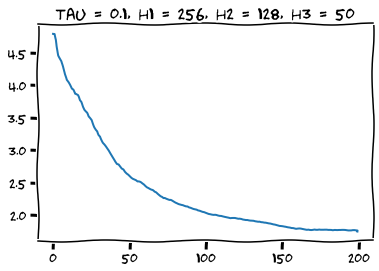

In [25]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

#10.0 Save trained weights on weights and bias account  

In [44]:
import os
resnet_simclr.save(os.path.join(wandb.run.dir, "resnet_simclr.h5"))
wandb.save('resnet_simclr.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[]

#11.0 Restore weights from weights and bias account

In [45]:
simclr_weights = wandb.restore('resnet_simclr.h5', run_path="abais/alzeimers_simclr/runs/1ofby58g")

# 12.0 Add a linear classifier projection head, train, test, evaluate

## 12.1 Load test image paths


In [46]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(test_images))

250


In [47]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

## 12.2 Train, test split. Train with 10% of imagenet

In [48]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [49]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 125/125 [00:00<00:00, 225.54it/s]


(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 224.64it/s]


(250, 224, 224, 3) (250,)


In [50]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## 12.3 Apply the weights from previously trained resNet_simclr in 7.0

In [51]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

#13.0 Visualization helpers for loss, acccuracy

## 13.1. Plot training loss, accuracy

In [52]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

# 14.0 Evaluate model with non-linear projections

In [53]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [54]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

## 14.1 Evaluate simclr with non-linear projections

In [55]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [56]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

## 14.2 Tensorboard integration

In [57]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

Epoch 1/35
2/2 [==============================] - 1s 463ms/step - loss: 3.4125 - accuracy: 0.1680 - val_loss: 3.5383 - val_accuracy: 0.1440
Epoch 2/35
2/2 [==============================] - 0s 24ms/step - loss: 3.2312 - accuracy: 0.1600 - val_loss: 3.3779 - val_accuracy: 0.1560
Epoch 3/35
2/2 [==============================] - 0s 23ms/step - loss: 3.0835 - accuracy: 0.1840 - val_loss: 3.2324 - val_accuracy: 0.1520
Epoch 4/35
2/2 [==============================] - 0s 25ms/step - loss: 2.9365 - accuracy: 0.2000 - val_loss: 3.1010 - val_accuracy: 0.1600
Epoch 5/35
2/2 [==============================] - 0s 23ms/step - loss: 2.8113 - accuracy: 0.2080 - val_loss: 2.9839 - val_accuracy: 0.1720
Epoch 6/35
2/2 [==============================] - 0s 23ms/step - loss: 2.6901 - accuracy: 0.2160 - val_loss: 2.8762 - val_accuracy: 0.1720
Epoch 7/35
2/2 [==============================] - 0s 37ms/step - loss: 2.5843 - accuracy: 0.2240 - val_loss: 2.7768 - val_accuracy: 0.1720
Epoch 8/35
2/2 [==========

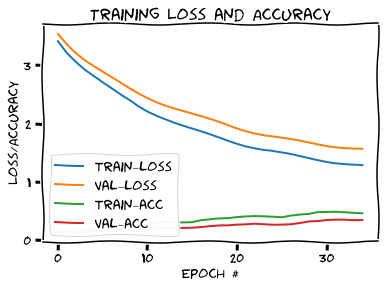

In [58]:
# Linear model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[tensorboard_callback])
plot_training(history)

# 15.0 Visualization helpers for TSNE

In [59]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

## 15.1 TSNE visualization with non-linear projections

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


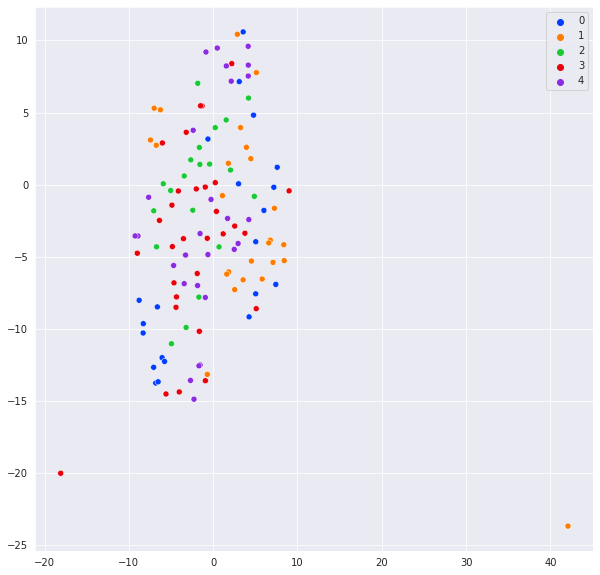

In [60]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)